In [1]:
from processing import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'

#dFast = readAndProcess('../Data/1-AChernev_080219_dir_HeLa_cyt_UCGA_fast.tsv', idCol, scoreCol)
dSlow = readAndProcess('../Data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol)

dSlow.head()

file read
strings converted to numbers
q-values estimated
ranks computed


,SpecId,Label,ScanNr,ExpMass,CalcMass,mass,peplen,charge2,charge3,charge4,...,precursor_purity,NuXL:XL_U,NuXL:XL_C,NuXL:XL_G,NuXL:XL_A,Peptide,Proteins,FDR,q-val,Rank
15534,controllerType=0controllerNumber=1scan=8704,1,8704,1075.096069,1075.098716,1075.096069,40,0,1,0,...,1.000000,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1
15647,controllerType=0controllerNumber=1scan=8757,1,8757,1075.099487,1075.098716,1075.099487,40,0,1,0,...,1.000000,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1
12279,controllerType=0controllerNumber=1scan=7273,1,7273,906.114624,906.114606,906.114624,44,0,0,1,...,0.969195,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGKSSHS.-,sp|P35527|K1C9_HUMAN,0.0,0.0,1
14073,controllerType=0controllerNumber=1scan=7991,1,7991,1336.114624,1336.114549,1336.114624,32,0,1,0,...,1.000000,0,0,0,0,K.KKEEEEDEEDEEDEEEEEDEEDEDEEEDDDDE.-,sp|P09429|HMGB1_HUMAN,0.0,0.0,1
14191,controllerType=0controllerNumber=1scan=8046,1,8046,1336.115234,1336.114549,1336.115234,32,0,1,0,...,0.992819,0,0,0,0,K.KKEEEEDEEDEEDEEEEEDEEDEDEEEDDDDE.-,sp|P09429|HMGB1_HUMAN,0.0,0.0,1


In [2]:
from sklearn import svm

def percolator(df, idColName, excludedCols, I = 10, svmIter = 20000, q = 0.05, plotEveryIter = False, suppressLog = False):
    # split decoys in half (?)
    df.sort_index(inplace = True)
    ixDecoys = list(df[df.Label == 0].index)
    ixFirstHalf = rd.sample(ixDecoys, k = (int(len(ixDecoys)/2)))
    
    # save second half of decoys for later and drop them from df
    ixSecondHalf = set(ixDecoys) - set(ixFirstHalf)
    scndDecoys = df.loc[ixSecondHalf,]
    df = df.drop(ixSecondHalf)
    
    # calculate the scores used for learning
    scores = [x for x in list(df.columns) if (x not in excludedCols)]

    # calculate negative training set
    # trim the negative training set so its size matches the positive training set
    # ixFalse = rd.sample(ixDecoys, k = len(ixTrue))
    ixFalse = ixFirstHalf
    falseTrain = df[scores].loc[ixFalse].values.tolist()
    
    scoreName = 'percolator_score'
    
    # iterate I times:
    for i in range(I):
        
        # choose positive training set by q-val
        # Maybe also use decoys with necessary q-value?
        trueTrain = df[scores][(df['q-val'] <= q) & (df.Label == 1)].values.tolist()
        
        # train linear svm
        train = falseTrain + trueTrain
        classes = [0] * len(falseTrain) + [1] * len(trueTrain)
        if(not suppressLog):
            print('Training in iteration {} starts!'.format(i + 1))
        W = svm.LinearSVC(dual = False, class_weight='balanced', max_iter = svmIter).fit(train, classes)
        
        # re-rank PSMs by using the svm-generated scores instead of scoreCol, re-calculating q-val
        X = df[scores].values.tolist()
        df[scoreName] = W.decision_function(X)
        df = calcQ(df, scoreName)
        if(plotEveryIter):
            pseudoROC(df, 0.05, title = 'Iteration {}'.format(i + 1))
            plt.show()
        if(not suppressLog):
            print('Iteration {} done!'.format(i + 1))
        
    # compute new decoy PSMs / use second half
    df = df[df.Label == 1]
    df = pd.concat([df, scndDecoys], sort = False)
    X = df[scores].values.tolist()
    df[scoreName] = W.decision_function(X)
    d = calcQ(df, scoreName)
    df = addRanks(d, idColName, scoreName)
    df.sort_values(scoreName, inplace = True, ascending = False)
    
    # return PSMs with new score
    return df

Seltsames Verhalten der Scores der SVM, siehe Linear_ML.ipynb letzte Zelle. Vielleicht müssen die Scores nochmal transformiert werden? Darum benutze ich allerdings predict_proba bzw. eine lineare SVM, bei der gibt es die Probleme nicht.

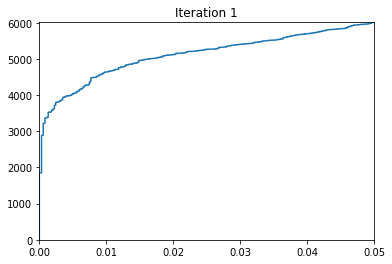

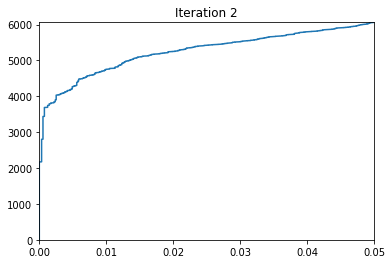

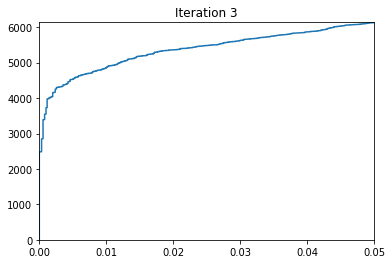

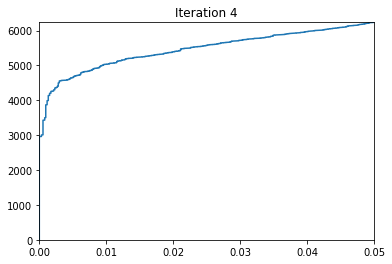

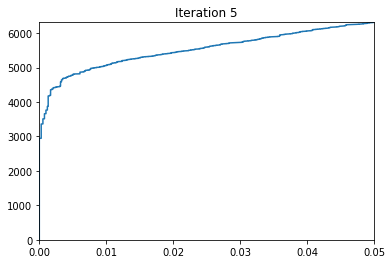

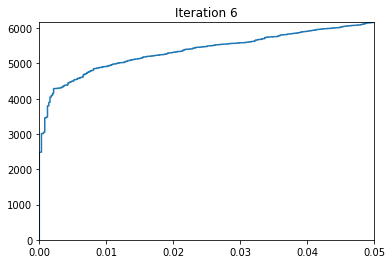

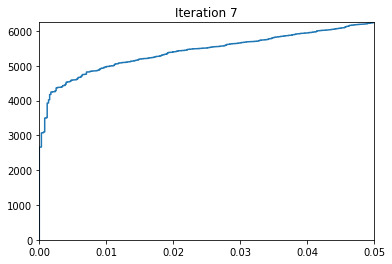

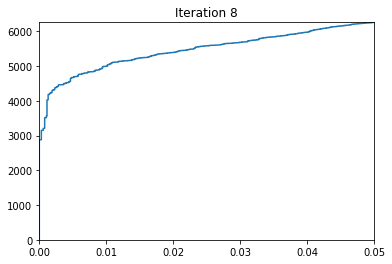

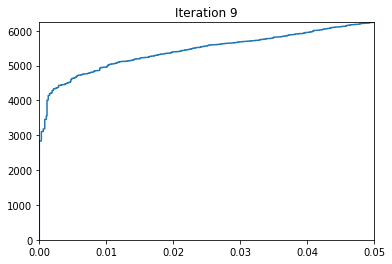

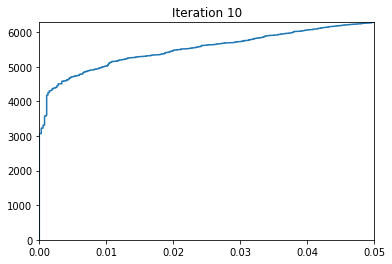

In [3]:
# ~16 minutes for svmIter = 20000
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'Rank']
p = percolator(dSlow, 'SpecId', excluded, svmIter = 30000, plotEveryIter=True, suppressLog=True)

In [4]:
p.head()

,SpecId,Label,ScanNr,ExpMass,CalcMass,mass,peplen,charge2,charge3,charge4,...,NuXL:XL_U,NuXL:XL_C,NuXL:XL_G,NuXL:XL_A,Peptide,Proteins,FDR,q-val,Rank,percolator_score
15534,controllerType=0controllerNumber=1scan=8704,1,8704,1075.096069,1075.098716,1075.096069,40,0,1,0,...,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1,42.761822
15647,controllerType=0controllerNumber=1scan=8757,1,8757,1075.099487,1075.098716,1075.099487,40,0,1,0,...,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGK.S,sp|P35527|K1C9_HUMAN,0.0,0.0,1,40.374448
24777,controllerType=0controllerNumber=1scan=12928,1,12928,698.643738,698.644040,698.643738,15,0,1,0,...,0,1,0,0,R.n[+43.005814000000001]NDTKEDVFVHQTAIK.K,"sp|P16989|YBOX3_HUMAN, sp|P67809|YBOX1_HUMAN, ...",0.0,0.0,1,33.774190
12279,controllerType=0controllerNumber=1scan=7273,1,7273,906.114624,906.114606,906.114624,44,0,0,1,...,0,0,0,0,R.GGSGGSHGGGSGFGGESGGSYGGGEEASGSGGGYGGGSGKSSHS.-,sp|P35527|K1C9_HUMAN,0.0,0.0,1,32.168218
14073,controllerType=0controllerNumber=1scan=7991,1,7991,1336.114624,1336.114549,1336.114624,32,0,1,0,...,0,0,0,0,K.KKEEEEDEEDEEDEEEEEDEEDEDEEEDDDDE.-,sp|P09429|HMGB1_HUMAN,0.0,0.0,1,30.211781


In [5]:
len(p[(p['q-val'] <= 0.01) & (p['Rank'] == 1)].index)

5239

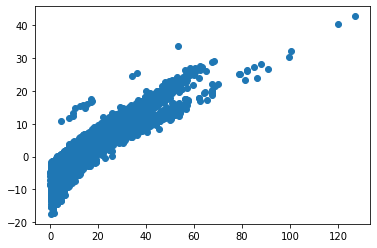

In [6]:
plt.scatter(p['NuXL:score'], p['percolator_score'])

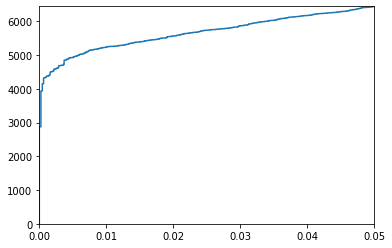

In [7]:
pseudoROC(p, 0.05)

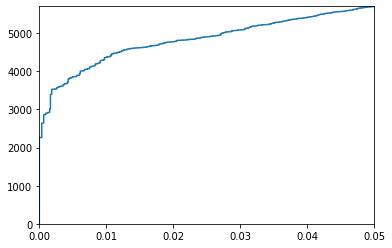

In [8]:
pseudoROC(calcQ(p, 'NuXL:score'), 0.05)